### Benchmark SeismicPro methods

| Function Name| Optimal target | Link |
| :---:        | :----: |  :---:|
|*__BATCH FUNCTIONS__*|||
| \_load_gather | for |[_load_gather](#load_gather)|
| \_load_combined_gather | for |  [_load_combined_gather](#load_combined_gather)|
|*__GATHER FUNCTIONS__*|||
| copy | threads | [copy](#copy) |
| dump | for | [dump](#dump) |
| sort | for | [sort](#sort) |
| pick_to_mask | threads | [pick_to_mask](#pick_to_mask) |
| mask_to_pick | for | [mask_to_pick](#mask_to_pick) |
| mute | threads | [mute](#mute) |
| calculate_semblance | threads | [calculate_semblance](#calculate_semblance) |
| calculate_residual_semblance | threads | [calculate_residual_semblance](#calculate_residual_semblance) |
| get_central_cdp | for | [get_central_cdp](#get_central_cdp) |
| apply_nmo | threads | [apply_nmo](#apply_nmo) |
| stack | for | [stack](#stack) |
| scale_standard | threads | [scale_standard](#scale_standard) |
| scale_maxabs | threads | [scale_maxabs](#scale_maxabs) |
| scale_minmax | threads | [scale_minmax](#scale_minmax) |
| crop | for | [crop](#crop) |
|*__SEMBLANCE__*|||
| calculate_stacking_velocity | for | [calculate_stacking_velocity](#calculate_stacking_velocity) |
|*__CROPPEDGATHER__*|||
| assemble_gather | threads | [assemble_gather](#assemble_gather) |


All results are obtained for the following configuration:
* CPU - Intel(R) Xeon(R) Gold 6242R CPU @ 3.10GHz x 20
* 512 Gb RAM

In [1]:
import sys
import dill

import numpy as np

sys.path.append('../..')
from benchmark import Benchmark
from seismicpro import Survey, SeismicDataset, Muter, StackingVelocity
from seismicpro.batchflow import Pipeline

/notebooks/V/SeismicPro/seismicpro/benchmark/../../seismicpro/batchflow/batchflow/notifier.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm as tqdm_auto


Define constants

In [2]:
# PATH = 'benchmark_data_1000x3000.sgy'
PATH = '/notebooks/V/benchmark_data/benchmark_data_1000x3000.sgy'
# CDP_PATH = './benchmark_data_for_sg_size_1_11_step_40_40_modulo_20_25.sgy'

BATCH_SIZES = list(range(1, 11)) + list(range(15, 51, 5))
N_ITERS = 25
TARGETS = ('for', 'threads')
SHUFFLE = 42

stacking_velocity = StackingVelocity.from_points(times=[0, 3000], velocities=[1600, 3500])

Create survey and the dataset

In [3]:
sur = Survey(PATH, header_index=['INLINE_3D', 'CROSSLINE_3D'], 
             header_cols='offset', name='raw')
sur.headers['FirstBreak'] = np.random.randint(0, 3000, len(sur.headers))

dataset = SeismicDataset(surveys=sur)

load_pipeline = Pipeline().load(src='raw', fmt='sgy')
sort_pipeline = load_pipeline + Pipeline().sort(src='raw', by='offset')

In [4]:
default_kwargs = dict(targets=TARGETS, batch_sizes=BATCH_SIZES, dataset=dataset)

### load_gather

In [ ]:
load_bm = Benchmark(method_name='load', method_kwargs={'src':'raw'},
                    root_pipeline=None, **default_kwargs)

load_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### load_combined_gather

In [ ]:
load_comb_bm = Benchmark(method_name='load', method_kwargs={'src':'raw', 'combined': True},
                         root_pipeline=None, **default_kwargs)

load_comb_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### copy

In [ ]:
copy_bm = Benchmark(method_name='copy', method_kwargs={'src':'raw', 'dst':'rawraw'},
                    root_pipeline=load_pipeline, **default_kwargs)

copy_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### dump

In [ ]:
dump_bm = Benchmark(method_name='dump', method_kwargs={'src':'raw', 'path':'./dump1'},
                    root_pipeline=load_pipeline, **default_kwargs)

dump_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### sort

In [ ]:
sort_bm = Benchmark(method_name='sort', method_kwargs={'src':'raw', 'by':'offset'},
                    root_pipeline=load_pipeline, **default_kwargs)

sort_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### pick_to_mask

In [ ]:
pcik_to_mask_bm = Benchmark(method_name='pick_to_mask', method_kwargs={'src':'raw'},
                            root_pipeline=load_pipeline, **default_kwargs)

pcik_to_mask_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### mask_to_pick

In [ ]:
mask_to_pick_ppl = load_pipeline + Pipeline().pick_to_mask(src='raw')
mask_to_pick_bm = Benchmark(method_name='mask_to_pick', method_kwargs={'src':'raw', 'threshold':0.5},
                            root_pipeline=mask_to_pick_ppl, **default_kwargs)

mask_to_pick_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### mute

In [ ]:
muter = Muter.from_points(offsets=[1000, 2000, 3000], times=[100, 300, 600])
mute_bm = Benchmark(method_name='mute', method_kwargs={'src': 'raw', 'muter': muter},
                    root_pipeline=load_pipeline, **default_kwargs)

mute_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### calculate_semblance

In [ ]:
semblance_kwargs = {'src': 'raw', 'velocities': np.linspace(1300, 5500, 140), 'win_size': 25}
semblance_bm = Benchmark(method_name='calculate_semblance', method_kwargs=semblance_kwargs,
                         root_pipeline=sort_pipeline, **default_kwargs)

semblance_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### calculate_residual_semblance

In [ ]:
res_semblance_kwargs = {
    'src': 'raw', 
    'stacking_velocity': stacking_velocity,
    'n_velocities': 140, 
    'win_size': 25
}
res_semblance_bm = Benchmark(method_name='calculate_residual_semblance', method_kwargs=res_semblance_kwargs,
                             root_pipeline=sort_pipeline, targets=TARGETS, batch_sizes=BATCH_SIZES[:-4], 
                             dataset=dataset)

res_semblance_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### get_central_cdp

In [ ]:
cdp_survey = Survey(CDP_PATH, header_index=['INLINE_3D', 'CROSSLINE_3D'], name='raw')
supergather_survey = cdp_survey.generate_supergathers(size=(1, 11), step=(40, 40), modulo=(20, 25))
supergather_dataset = SeismicDataset(surveys=supergather_survey)

cdp_kwargs = default_kwargs.copy()
cdp_kwargs.update(dataset=supergather_dataset)

get_central_cdp_bm = Benchmark(method_name='get_central_cdp', method_kwargs={'src':'raw'},
                               root_pipeline=load_pipeline, **cdp_kwargs)

get_central_cdp_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### apply_nmo

In [ ]:
apply_nmo_bm = Benchmark(method_name='apply_nmo', method_kwargs={'src': 'raw', 'stacking_velocity':stacking_velocity},
                         root_pipeline=load_pipeline, **default_kwargs)
apply_nmo_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### stack

In [ ]:
apply_nmo_bm = Benchmark(method_name='stack', method_kwargs={'src': 'raw'},
                         root_pipeline=load_pipeline, **default_kwargs)
apply_nmo_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### scale_standard


In [ ]:
scale_std_bm = Benchmark(method_name='scale_standard', method_kwargs={'src':'raw'},
                         root_pipeline=load_pipeline, **default_kwargs)

scale_std_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### scale_maxabs

In [ ]:
scale_maxabs_bm = Benchmark(method_name='scale_maxabs', method_kwargs={'src':'raw'},
                            root_pipeline=load_pipeline, **default_kwargs)

scale_maxabs_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### scale_minmax

In [ ]:
scale_minmax_bm = Benchmark(method_name='scale_minmax', method_kwargs={'src':'raw'},
                            root_pipeline=load_pipeline, **default_kwargs)

scale_minmax_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### crop

100%|██████████| 36/36 [03:29<00:00,  5.82s/it]
0it [03:30, ?it/s]


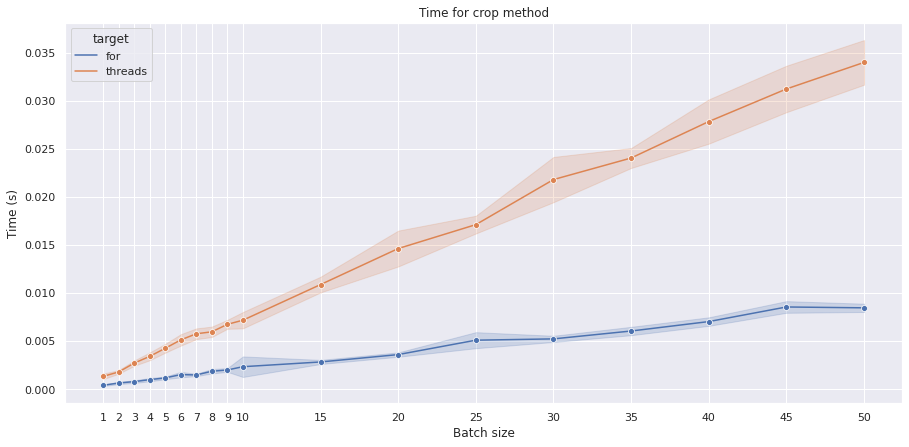

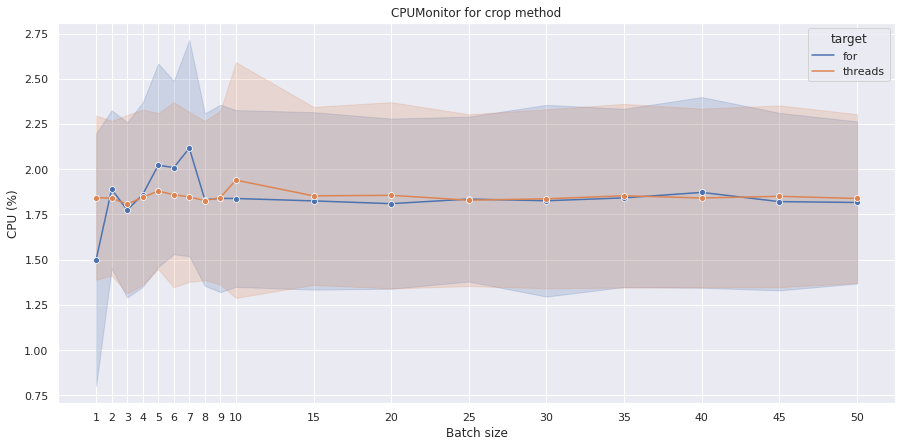

In [5]:
method_kwargs = {'src': 'raw', 'dst': 'cropped', 'crop_shape': (20, 1000), 'origins': 'random', 'n_items': 16}

crop_bm = Benchmark(method_name='crop', method_kwargs=method_kwargs, root_pipeline=load_pipeline, **default_kwargs)

crop_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### calculate_stacking_velocity

In [ ]:
stacking_velocity_pipeline = sort_pipeline + Pipeline().calculate_semblance(src="raw", velocities=np.linspace(1400, 5000, 150), dst="semb")
method_kwargs = {'src': 'semb', 'start_velocity_range': (1400, 1800), 'end_velocity_range': (3500, 5000)}

stacking_velocity_bm = Benchmark(method_name='calculate_stacking_velocity', method_kwargs=method_kwargs,
                                 root_pipeline=stacking_velocity_pipeline, **default_kwargs)

stacking_velocity_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### assemble_gather

100%|██████████| 36/36 [08:39<00:00, 14.43s/it]


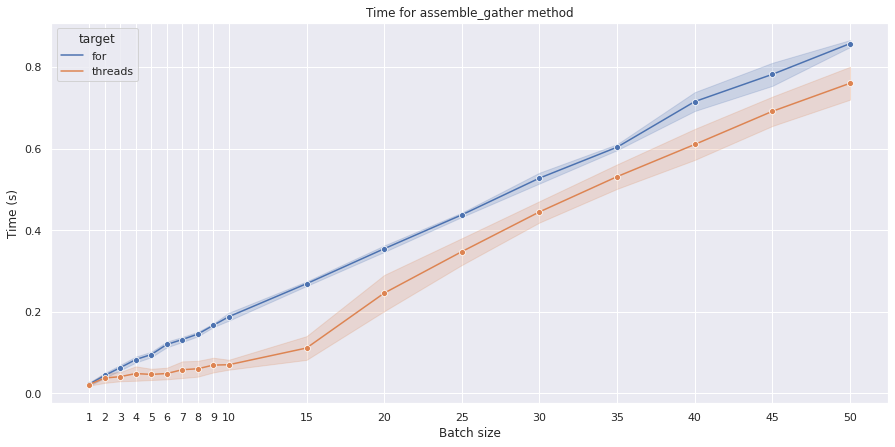

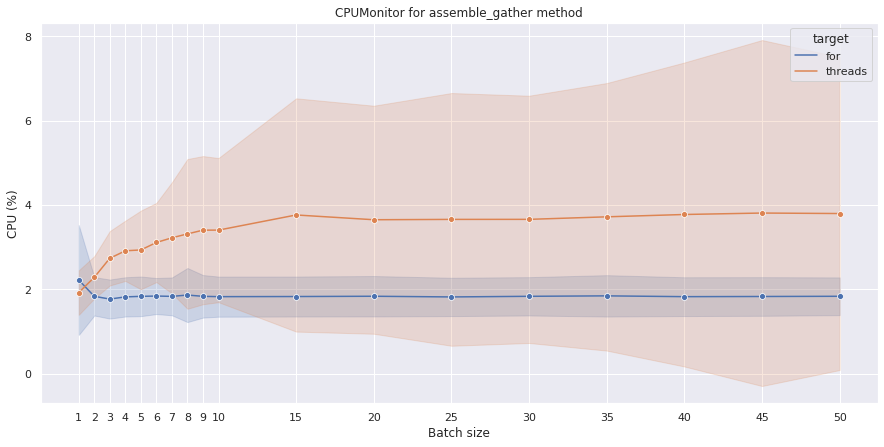

In [6]:
crop_grid_pipeline = load_pipeline + Pipeline().crop(src='raw', dst='cropped', origins='grid', crop_shape=(224, 224))

assemble_bm = Benchmark(method_name='assemble_gather', method_kwargs={'src': 'cropped'}, 
                        root_pipeline=crop_grid_pipeline, **default_kwargs)

assemble_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)